In [12]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('predict.csv', index_col=0)
data.head()

,predict,predict_label,real_churn
0,0.024180,0,0
1,0.088400,0,0
2,0.057828,0,0
3,0.148568,0,0
4,0.128363,0,0


In [8]:
data[['predict_label', 'real_churn']].value_counts()

predict_label  real_churn
0              0             6812
1              0              567
0              1              467
1              1              154
dtype: int64

In [9]:
def top_p(df, sort_by, percentage):
    df = df.sort_values(by='predict', ascending=False)
    percentile_index = int(len(df) * percentage)
    return df[:percentile_index]


def economic_effect_model(users_df, involved_rate, user_retention_cost=10, avg_revenue_per_user=15, churn_return_rate=0.5,
                          model_quality=None):   
    if model_quality:
        # Для моделирования повышения качества модели, просто выкинем процент ошибок из текущей.
        # Это будет анлогично улучшению roc_auc, тк мы выкидываем ошибки первого и второго рода. 
        error_indexes = users_df.index[users_df.predict_label != users_df.real_churn]
        users_df = users_df.drop(index=error_indexes[:int(len(error_indexes) * (model_quality - 1))])
    
    retention_users_df = top_p(
        users_df, sort_by='predict', percentage=involved_rate)

    users_count = len(users_df)
    retention_users_count = len(retention_users_df)
    retention_churn_count = len(
        retention_users_df[retention_users_df.real_churn == 1])
    churn_return_count = retention_churn_count * churn_return_rate
    churn_count = len(users_df.real_churn == 1)
    churn_after_retention_count = churn_count - churn_return_count

    # затраты на кампанию
    retention_cost = user_retention_cost * retention_users_count

    # доход при проведении компании
    retention_revenue = (
        users_count - churn_after_retention_count) * avg_revenue_per_user
    retention_profit = retention_revenue - retention_cost

    # доход без компании
    no_retention_profit = (users_count - churn_count) * avg_revenue_per_user

    return retention_profit - no_retention_profit


def get_max_profit_values(involved, profit):
    def get_max_pairwaise(prev, current):
        _, b_prev = prev
        _, b_current = current

        if b_current > b_prev:
            return current
        else:
            return prev

    return reduce(get_max_pairwaise, zip(involved, profit))

def get_retention_profit(involved_rate, data, quality, kwargs):
    return [economic_effect_model(data, x, model_quality=quality, **kwargs) for x in involved_rate]

'Топ для применения удержания: 4.67%'

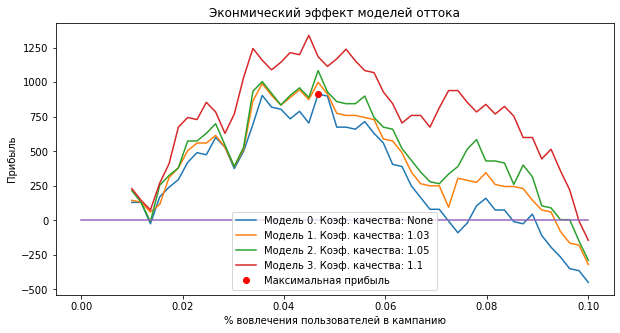

In [16]:
# Параметры кампании по удержанию
comon_params = {
    'avg_revenue_per_user': 100,
    'churn_return_rate': 0.7,
    'user_retention_cost': 15,
}

max_involved_rate = 0.1
involved_rate = np.linspace(0.01, max_involved_rate, 50)

model_qulities = [None, 1.03, 1.05, 1.1]
profits = [get_retention_profit(involved_rate, data, quality, comon_params) for quality in model_qulities]

plt.figure(figsize=(10, 5)) 
for i, (quality, profit) in enumerate(zip(model_qulities, profits)):
    plt.plot(involved_rate, profit, label=f'Модель {i}. Коэф. качества: {quality}')

best_rate, max_profit = get_max_profit_values(involved_rate, profits[0])
plt.plot(best_rate, max_profit, 'ro', label=f'Максимальная прибыль')

plt.ylabel(f'Прибыль')
plt.xlabel('% вовлечения пользователей в кампанию')
plt.plot([0, max_involved_rate], [0, 0])
plt.title(f'Эконмический эффект моделей оттока')
plt.legend()

f'Топ для применения удержания: {round(best_rate * 100, 2)}%'

 Значения ниже прямой - модель не эффективна. Максимальная эффективность базовой модели отмечена красной точкой на графике. Улучшение качества модели имеет экономический смысл.